In [1]:
#%%writefile Get_FastPulse.py
#import ROOT
import struct
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import scipy.stats as stats 
import numpy as np
import pandas as pd
from scipy.fftpack import fft,ifft
from scipy.optimize import curve_fit

In [2]:
#read function
def read_header(run_filename):
    stream = open(run_filename,"rb")
    print("open file ",run_filename)
    pstt = 0.
    FiredD = 0
    V1724_1_DAC = [0]*8
    V1724_1_Tg = [0]*8
    V1724_1_twd = 0
    V1724_1_pretg = 0
    V1724_1_opch = 0
    V1724_2_DAC = [0]*8
    V1724_2_Tg = [0]*8
    V1724_2_twd = 0
    V1724_2_pretg = 0
    V1724_2_opch = 0
    V1721_DAC = [0]*8 #V1724-1 Channel DAC     
    V1721_Tg = [0]*8  #V1724-1 Trigger Settings
    V1721_twd = 0      #V1724-1 Time Window     
    V1721_pretg = 0    #V1724-1 Pre Trigger     
    V1721_opch = 0     #V1724-1 Opened Channel
    V1729_th_DAC = 0
    V1729_posttg = 0
    V1729_tgtype = 0
    V1729_opch = 0
    rstt = 0.
    redt = 0.

    print("***************************Run Header**************************************\n");
    pstt = struct.unpack("d", stream.read(8))[0]
    print("* Program Start Time:",pstt," s.\n");
    FiredD = struct.unpack("I", stream.read(4))[0]
    print("* Fired Devices: ",FiredD," ( V1724-1 | V1724-2 | V1729)\n\n")

    print("* V1724-1 Channel DAC:      ")
    for i in range(8):
        V1724_1_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_1_DAC[i],"\t")
    print("\n")

    V1724_1_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Time Window:  ",V1724_1_twd,"\n")
    V1724_1_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Pre Trigger: ",V1724_1_pretg,"\n")
    V1724_1_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Opened Channel: ",V1724_1_opch,"\n\n")

    #V1724-2 Settings
    print("* V1724-2 Channel DAC:      ");
    for i in range(8):
        V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_2_DAC[i],"\t")
    print("\n")

    V1724_2_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Time Window:  ",V1724_2_twd,"\n")
    V1724_2_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Pre Trigger: ",V1724_2_pretg,"\n")
    V1724_2_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Opened Channel: ",V1724_2_opch,"\n\n")

    V1729_th_DAC = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Threshold DAC:  ",V1729_th_DAC,"\n")
    V1729_posttg = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Post Trigger: ",V1729_posttg,"\n")
    V1729_tgtype = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Trigger Type: ",V1729_tgtype,"\n")
    V1729_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Opened Channel: ",V1729_opch,"\n\n")

    #V1721 Settings
    print("* V1721 Channel DAC:        ")
    for i in range(8):
        V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_2_DAC[i],"\t")
    print("\n")
    V1721_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Time Window: ",V1721_twd,"\n")
    V1721_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Pre Trigger: ",V1721_pretg,"\n")
    V1721_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Opened Channel: ",V1724_1_opch,"\n")

    rstt = struct.unpack("d", stream.read(8))[0]
    print("* Run Start Time: ",rstt," s.\n")
    print("***************************************************************************\n");

    #event header
    Hit_pat = 0
    V1729_tg_rec = 0
    Evt_deadtime = 0
    Evt_starttime = 0
    Evt_endtime = 0
    V1724_1_tgno = 0
    V1724_2_tgno = 0
    V1721_tgno = 0
    V1724_1_tag = 0
    print("current point position: ",stream.tell(),"\n")
    
    return V1724_1_opch,V1724_1_twd

# read an event pulse, output the preamp pulse
def read_event(filename,eventN,V1724_1_opch,V1724_1_twd):
    MAX_WINDOWS = 12000
    EVENT_NUMBER = 10000
    fit_start = 0
    run = int(eventN/EVENT_NUMBER)
    evt = eventN%EVENT_NUMBER+1

    stream = open(filename,"rb")
    
    
    stream.seek(168,0)   #Shift to the evt_num Event
    stream.seek(4*9*(evt-1),1)
    stream.seek(2*V1724_1_opch*V1724_1_twd*(evt-1),1)

    Hit_pat = struct.unpack("I", stream.read(4))[0]
    V1729_tg_rec = struct.unpack("I", stream.read(4))[0]
    Evt_deadtime = struct.unpack("I", stream.read(4))[0]
    Evt_starttime = struct.unpack("I", stream.read(4))[0]
    Evt_endtime = struct.unpack("I", stream.read(4))[0]
    V1724_1_tgno = struct.unpack("I", stream.read(4))[0]
    V1724_2_tgno = struct.unpack("I", stream.read(4))[0]
    V1721_tgno = struct.unpack("I", stream.read(4))[0]
    V1724_1_tag = struct.unpack("I", stream.read(4))[0]
    V1724_1_pulse = np.zeros((V1724_1_opch,V1724_1_twd))
    for k in range(V1724_1_opch):
        for l in range(V1724_1_twd):
            V1724_1_pulse[k][l] = struct.unpack("H", stream.read(2))[0]
    return V1724_1_pulse

# get pulse parameter (by the way of imput func())
def get_par(filename,eventN,V1724_1_opch,V1724_1_twd,func,*args):
    V1724_1_pulse=read_event(filename,eventN,V1724_1_opch,V1724_1_twd)
    return func(V1724_1_pulse[1],*args)


def get_HSfunc(filename,pulser_index,V1724_1_opch,V1724_1_twd):
    L=0
    H=12000
    HSfunc=np.zeros((H-L,),dtype=complex)
    n=len(pulser_index)
    print(n)
    for index in pulser_index:
        V1724_1_pulse=read_event(filename,index,V1724_1_opch,V1724_1_twd)
        v_in=V1724_1_pulse[0][0:2000].mean()-V1724_1_pulse[0]
        v_out=V1724_1_pulse[1][0:2000].mean()-V1724_1_pulse[1]
        #fft
        fftv_in=fft(v_in[L:H])
        fftv_out=fft(v_out[L:H])
       
        HSfunc+=fftv_out          # hit response function
        
    HSfunc=HSfunc/n
    return HSfunc
    
def plot_HSfunc(HSfunc):
    abs_HSfunc=np.abs(HSfunc)
    normal_HSfunc=abs_HSfunc[0:6000]/12000
    rsp=ifft(HSfunc)
    fig, ax = plt.subplots(2,1)
    ax[0].plot(normal_HSfunc[0:10])
    ax[0].set(xlabel='W(Hz)', ylabel='', title='H(w) spectrum')
    ax[0].grid()
    ax[1].plot(rsp)
    ax[1].set(xlabel='t', ylabel='', title='Hit response function ')
    plt.show()
    

def mytanh(x,par0,par1,par2,par3):
    result = par0*(np.tanh(par3*(x-par2))) + par1
    return result

def tanh_generalized(x,par0,par1,par2,par3,par4,par5,par6):
    x=par0*(x-par1)
    x1=par2*x**3+par3*x+par4
    result=par5*((np.exp(x)-np.exp(-x1))/(np.exp(x)+np.exp(-x1)))+par6
    return result

def get_risetime(pulse_,divide_point): #must from small to large
    pulse=(pulse_[3000:3050].mean()-pulse_[3000:3700])
    pulse_max=pulse.max()
    pulse=pulse/float(pulse_max)

    n=len(divide_point)
    
    risetime=np.zeros((n,),dtype=float)
    
    i=0
    for t in np.arange(pulse.size):
        while(i<n and pulse[t]>divide_point[i]):
            #interpolate
            risetime[i]=interpolate(t-1,pulse[t-1],t,pulse[t],divide_point[i])
            #print(t,pulse[t],risetime[i])
            i+=1
##############        plot the interolated point  
    print(divide_point)
    print(risetime)
    fig, ax = plt.subplots(2,1,figsize=(14,10),dpi=500)
    time=np.linspace(0,120,12000)
    ax[0].plot(time[3000:3700], pulse)
    ax[1].plot(time[3320:3370], pulse[320:370])
    ax[1].plot(time[3320:3370], pulse[320:370],'og')
    ax[1].plot((risetime+0.3)/100.+30, divide_point,'or')

    ax[0].set(xlabel='time(us)', ylabel='v',
       title='pre amp pulse')
    ax[1].set(xlabel='time(us)', ylabel='v',
       title='rising edge')
    ax[1].grid()
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.2)
    plt.show()
#     fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/rising_time_par.png")
    
#################

    return risetime[1:n]-risetime[0:n-1]

def interpolate(x1,y1,x2,y2,d):
    return (d-y1)*(x2-x1)/(y2-y1)+x1

def damping(x,A,w,phi,tao,a1,a2,a3):
    exp=np.exp(-x/tao)
    sin=np.sin(w*x+phi)
    return A*sin*exp+a1*x**2+a2*x+a3



[ 0.49646289  0.4893981   0.43786136 46.69568224]
[12.          0.5         3.2         1.23425182  3.13466429  0.49859211
  0.49285769]


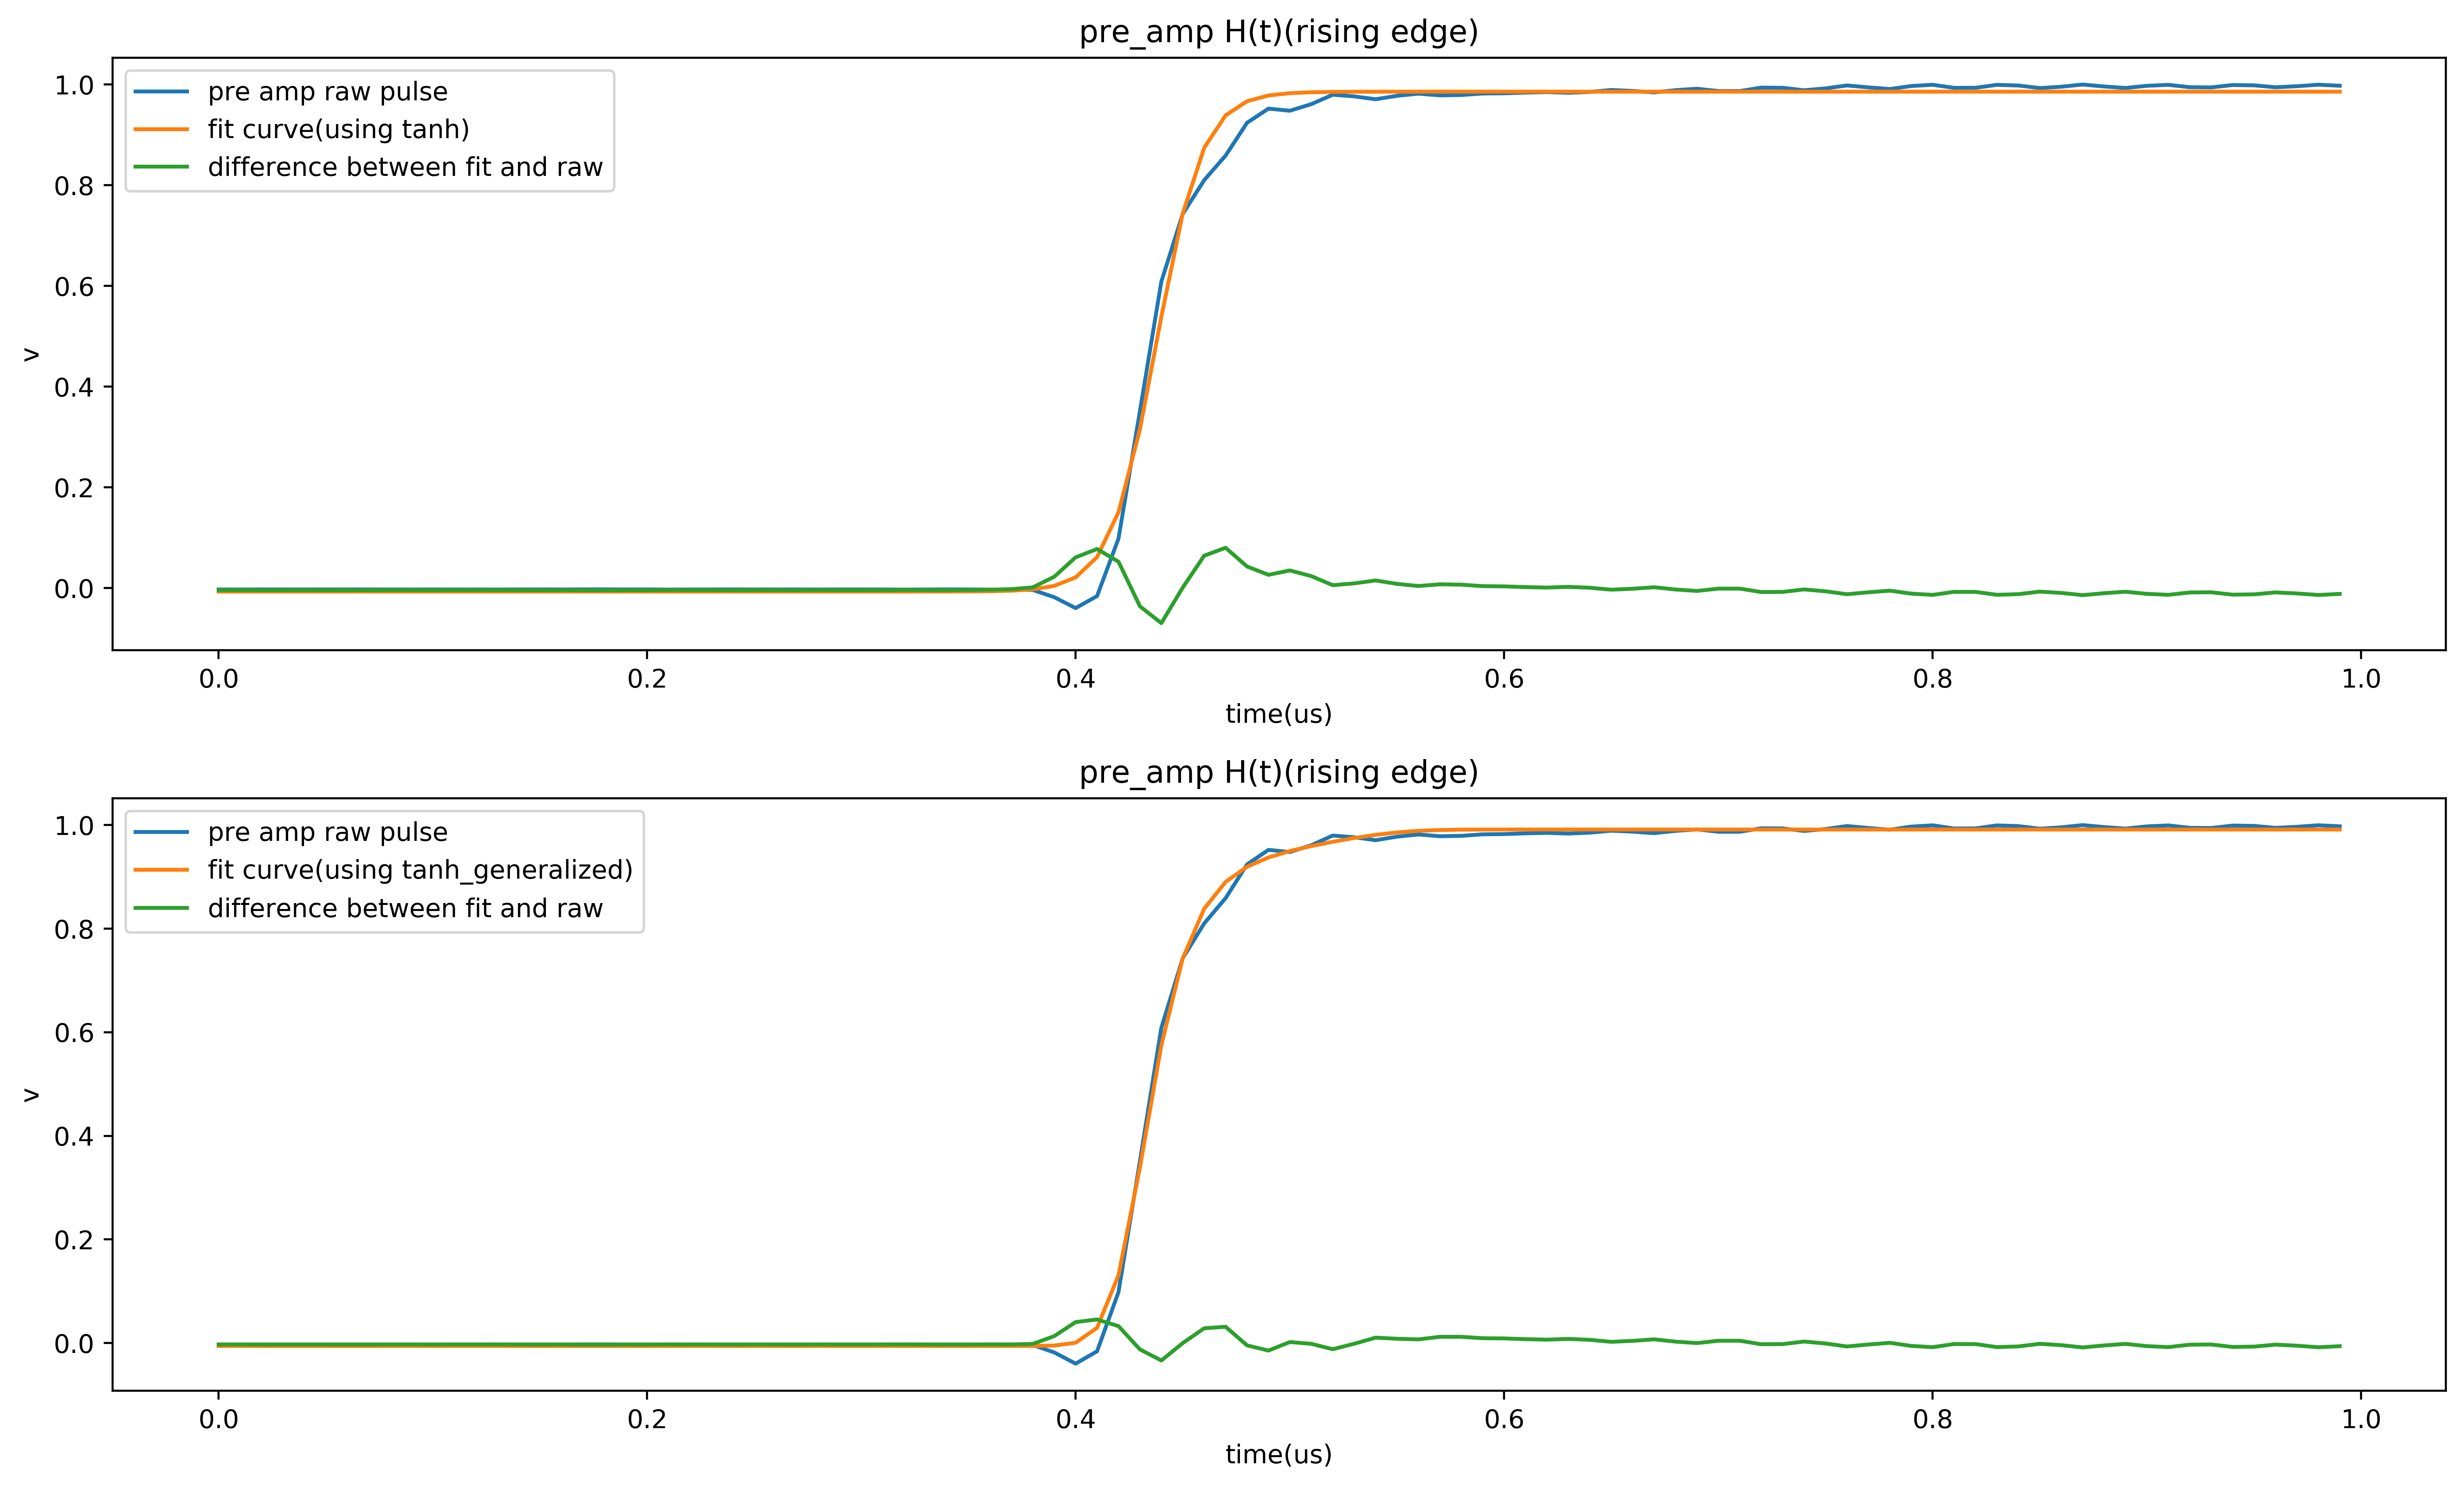

[12.          0.5         3.2         1.23425182  3.13466429  0.49859211
  0.49285769]


In [16]:
#read the header
path="G:/WaveResponse/"
#filename = path+"20200712_run2_pulser_ph1000_2_3106D_BEGe_2026_6us_0.5_5_FADC_RAW_Data_0.bin"
filename = path+"20201120_run4_pulser_BEGe_1470_2026_6us_0.5_5_FADC_RAW_Data_0.bin"
V1724_1_opch,V1724_1_twd=read_header(filename)

open file  G:/WaveResponse/20201120_run4_pulser_BEGe_1470_2026_6us_0.5_5_FADC_RAW_Data_0.bin
***************************Run Header**************************************

* Program Start Time: 3688710617.2514644  s.

* Fired Devices:  1  ( V1724-1 | V1724-2 | V1729)


* V1724-1 Channel DAC:      
59535 	
7343 	
59343 	
57343 	
37343 	
37343 	
57343 	
57343 	


* V1724-1 Time Window:   6000 

* V1724-1 Pre Trigger:  1500 

* V1724-1 Opened Channel:  3 


* V1724-2 Channel DAC:      
57343 	
57343 	
57343 	
57343 	
57343 	
8192 	
47343 	
47343 	


* V1724-2 Time Window:   8000 

* V1724-2 Pre Trigger:  2000 

* V1724-2 Opened Channel:  4 


* V1729 Threshold DAC:   2060 

* V1729 Post Trigger:  0 

* V1729 Trigger Type:  1 

* V1729 Opened Channel:  4 


* V1721 Channel DAC:        
58000 	
52000 	
57343 	
8192 	
8192 	
8192 	
8192 	
47343 	


* V1721 Time Window:  12000 

* V1721 Pre Trigger:  12000 

* V1721 Opened Channel:  3 

* Run Start Time:  3688710617.2793903  s.

***************

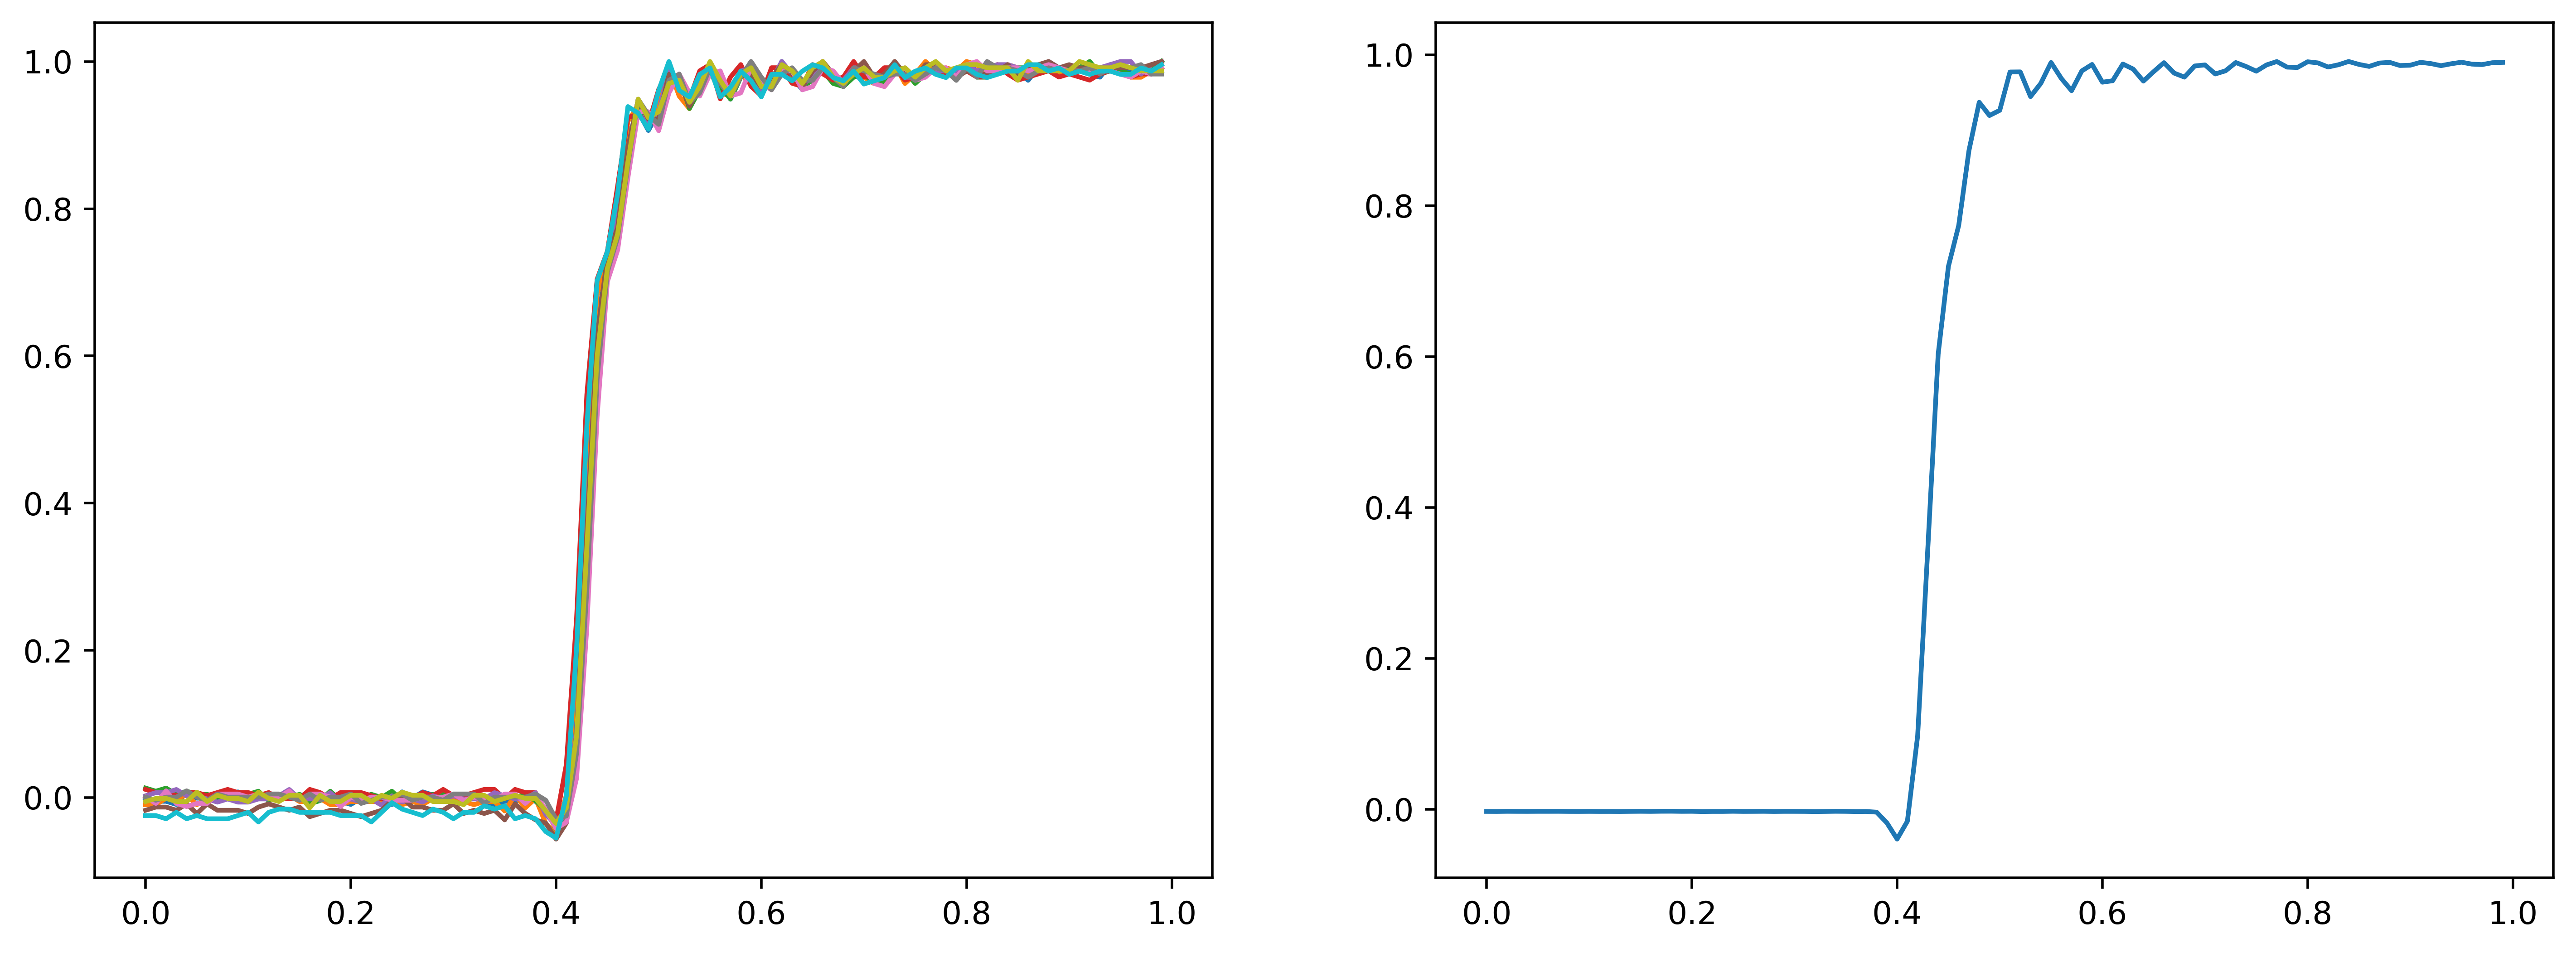

In [27]:
V1724_1_pulse=read_event(filename,3,V1724_1_opch,V1724_1_twd)
fig, ax = plt.subplots(1,2,figsize=(14,5),dpi=500)
for i in range(10):
    ax[0].plot(np.linspace(0,0.99,100),rising_edge_pulse[:,i])
ax[1].plot(np.linspace(0,0.99,100),AvePulse)
plt.show()

In [93]:
#save the rising edge pulse as .npy file
front_L=40
after_L=60
rising_L=front_L+after_L
EventN=10000            #event number of each file

pulser_edge_pulse=np.zeros((rising_L,EventN),dtype=float)
rising_edge_pulse=np.zeros((rising_L,EventN),dtype=float)
rising_time_point=np.zeros((EventN,))
print(rising_edge_pulse.shape)
pulser_index=[]
j=0
for i in range(10000):
    if (j<EventN):
        V1724_1_pulse=read_event(filename,i,V1724_1_opch,V1724_1_twd)
        if ((V1724_1_pulse[2,V1724_1_twd-1]-V1724_1_pulse[2,0])>3000):
            pulser_index.append(i)
            t0=np.argmax(V1724_1_pulse[1])
            if(t0>1000 and t0<2000):
                rising_edge_pulse[:,j]=V1724_1_pulse[1][0:1000].mean()-V1724_1_pulse[1,t0-front_L:t0+after_L]
                pulser_edge_pulse[:,j]=V1724_1_pulse[2,t0-front_L:t0+after_L]-V1724_1_pulse[2][0:100].mean()
                rmax=rising_edge_pulse[:,j].max()
                pmax=pulser_edge_pulse[rising_L-1,j]
                rising_edge_pulse[:,j]=rising_edge_pulse[:,j]/rmax
                pulser_edge_pulse[:,j]=pulser_edge_pulse[:,j]/pmax
                rising_time_point[j]=t0
                j+=1 
                if(j%1000==0):
                    print('j = ',j)
# np.save("E:/CDEX/ovbb/WaveSimulation/response/Pulser_Index.npy",pulser_index)
# np.save("E:/CDEX/ovbb/WaveSimulation/response/rising_edge_pulse.npy",rising_edge_pulse)
# np.save("E:/CDEX/ovbb/WaveSimulation/response/rising_time_point.npy",rising_time_point)
# np.save("E:/CDEX/ovbb/WaveSimulation/response/pulser_edge_pulse.npy",pulser_edge_pulse)

(100, 10000)
j =  1000
j =  2000
j =  3000
j =  4000
j =  5000
j =  6000
j =  7000
j =  8000
j =  9000


In [4]:
pulser_index=np.load("E:/CDEX/ovbb/WaveSimulation/response/Pulser_Index.npy")
rising_edge_pulse=np.load("E:/CDEX/ovbb/WaveSimulation/response/rising_edge_pulse.npy")
rising_time_point=np.load("E:/CDEX/ovbb/WaveSimulation/response/rising_time_point.npy")
pulser_edge_pulse=np.load("E:/CDEX/ovbb/WaveSimulation/response/pulser_edge_pulse.npy")

(40,)


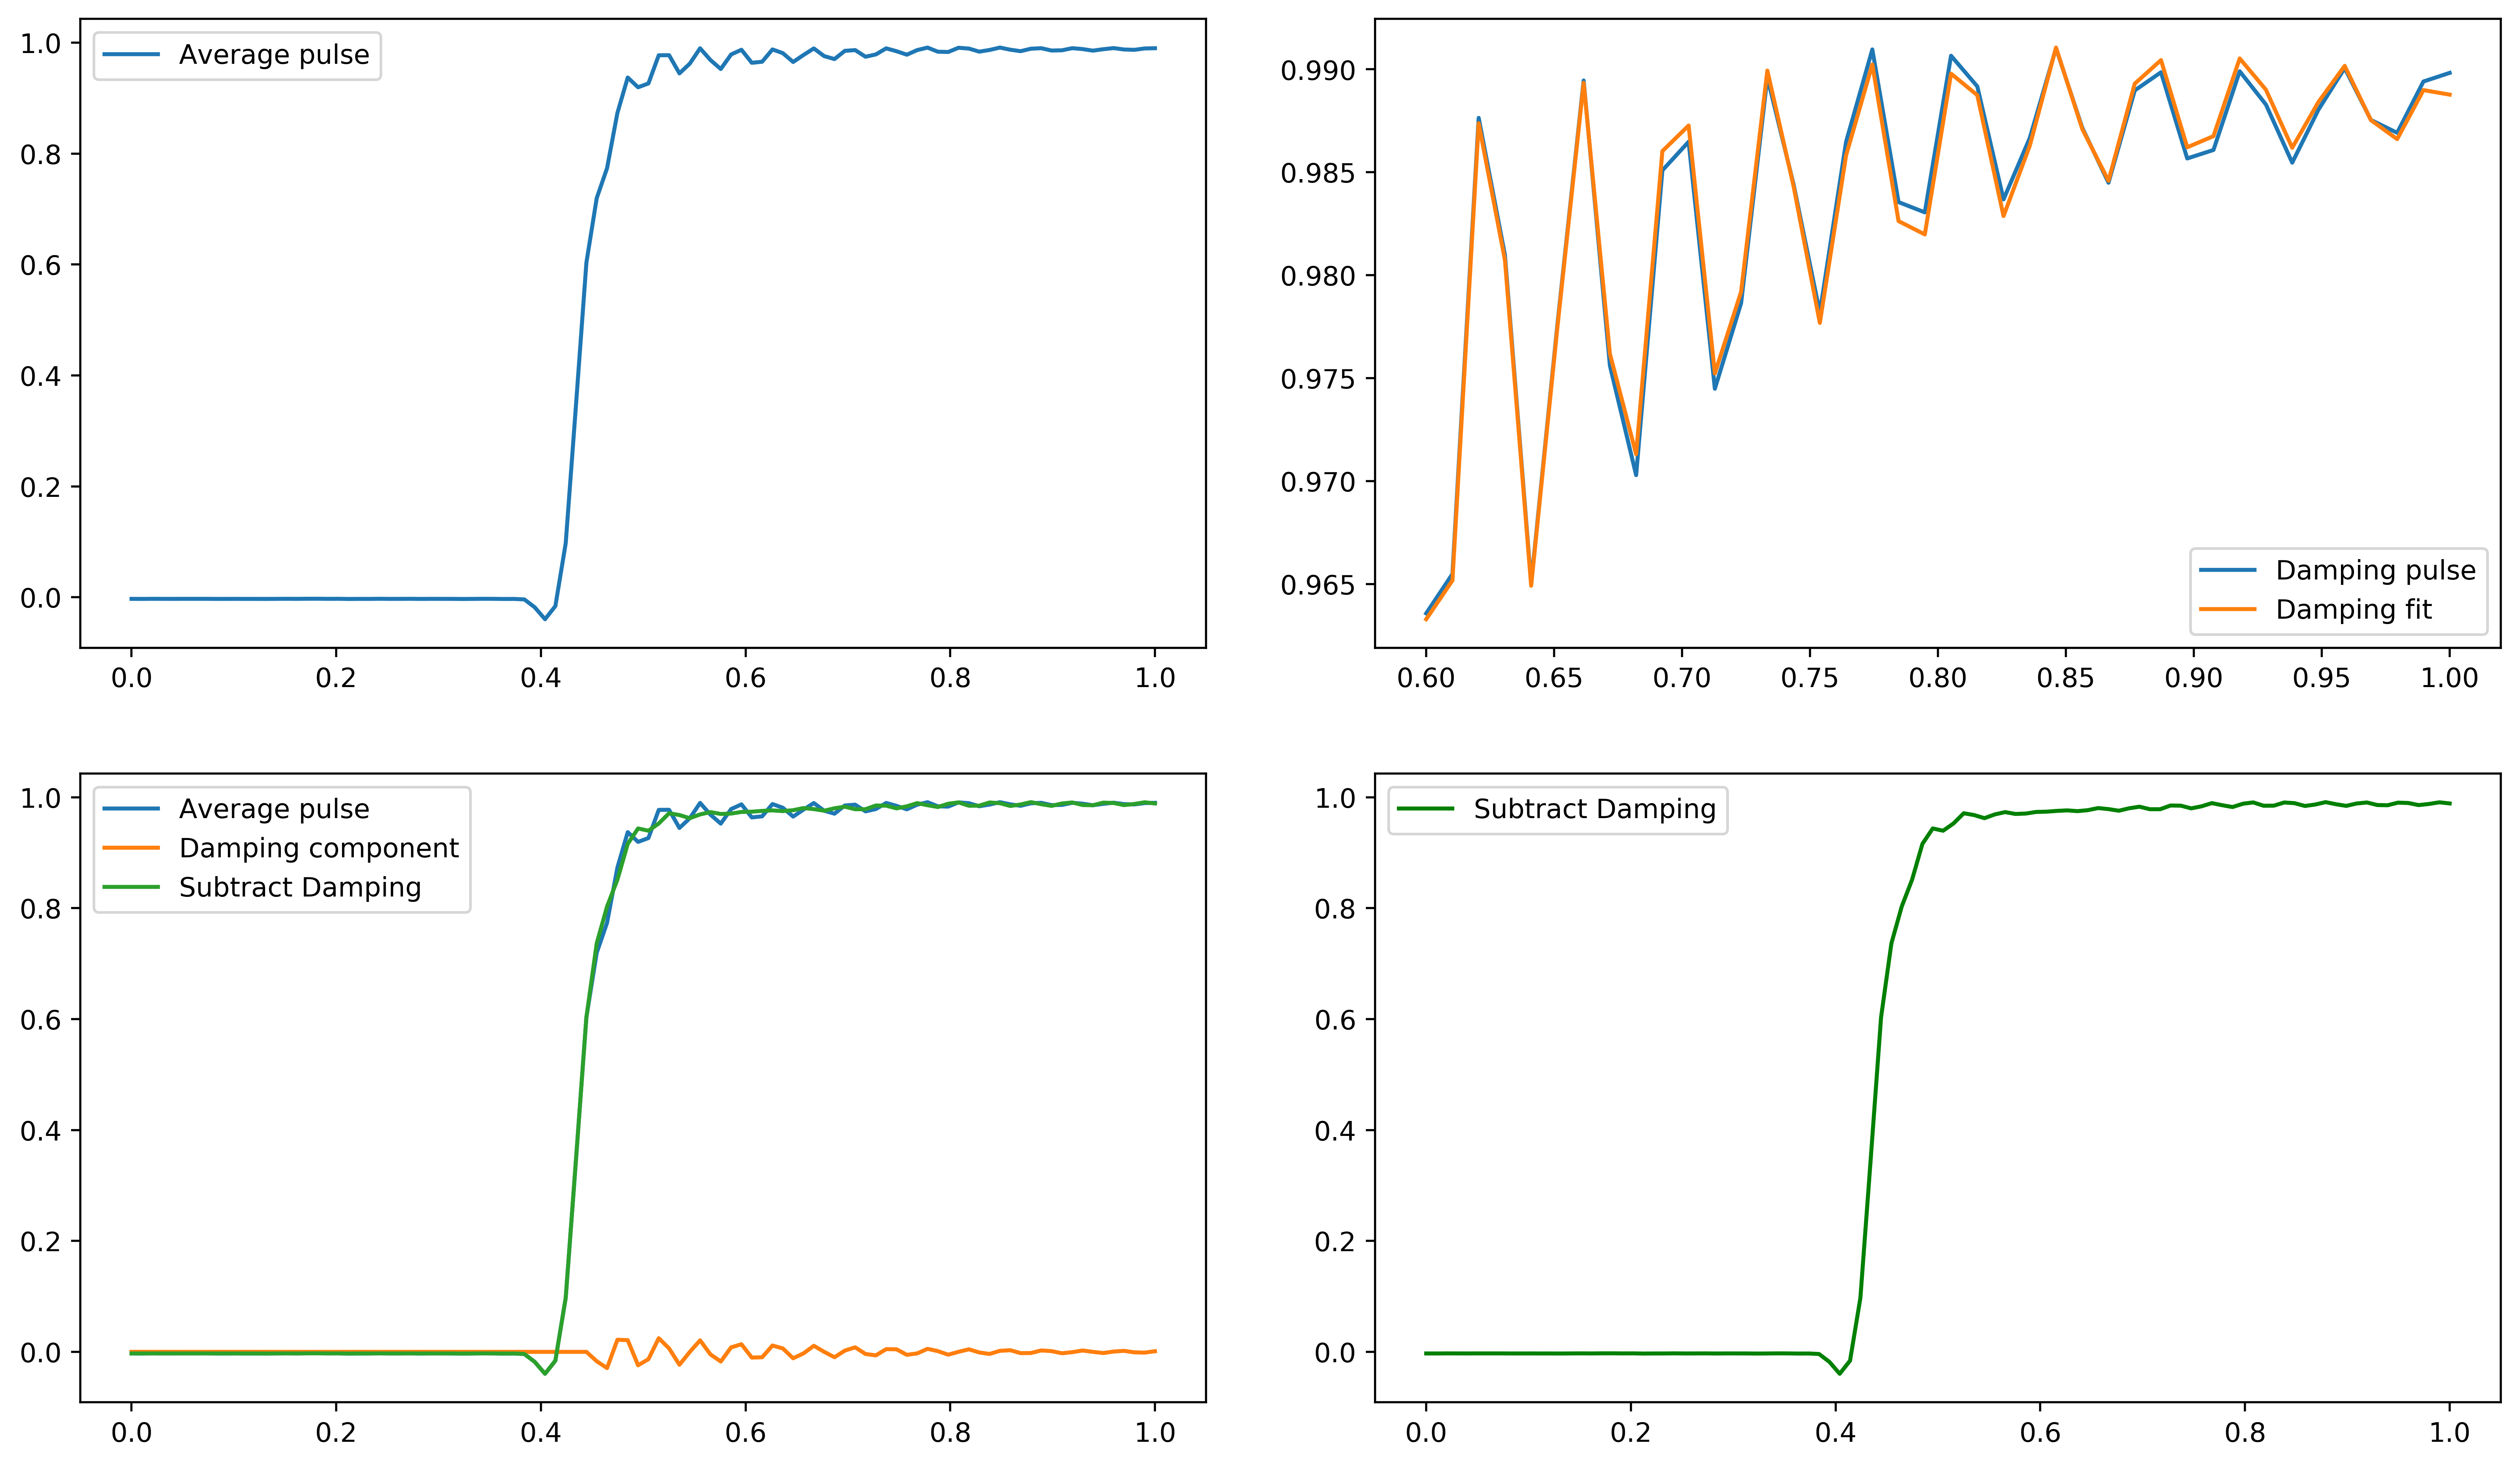

[ 1.56245037e-02  1.69224766e+02  3.86204823e+00  1.71828321e-01
 -1.32133656e-01  8.83258105e-02  9.73594879e-01]


In [5]:
AveNum=9000
StartNum=0
AvePulse=np.zeros((100,),dtype=float)
SumArray=np.ones((AveNum,),dtype=float)/AveNum
AvePulse=np.dot(rising_edge_pulse[:,StartNum:StartNum+AveNum],SumArray)

#######################
damping_curve=AvePulse[60:100]
par_bounds_damp=([0.01,100,0,0.1,-0.2,-1,0.8],[0.02,300,7,0.4,0,1,1])
time=np.linspace(0,0.4,40)
popt,pcov=curve_fit(damping,time,damping_curve,bounds=par_bounds_damp)
fit_sig_damp=damping(time,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
print(fit_sig_damp.shape)
damping_component=np.zeros((100,),dtype=float)
damping_component[45:100]=damping(np.linspace(0,0.54,55)-0.15,popt[0],popt[1],popt[2],popt[3],0,0,0)
fig, ax = plt.subplots(2,2,figsize=(14,8),dpi=500)
ax[0,0].plot(np.linspace(0,1,100),AvePulse,label="Average pulse")
ax[0,1].plot(time+0.6,damping_curve,label="Damping pulse")
ax[0,1].plot(time+0.6,fit_sig_damp,label="Damping fit")
#ax[1,0].plot(np.linspace(0,1,100),damping_component+0.98)
#ax[1,0].plot(time+0.6,damping_curve-damping_component[60:100])
ax[1,0].plot(np.linspace(0,1,100),AvePulse,label="Average pulse")
ax[1,0].plot(np.linspace(0,1,100),damping_component,label="Damping component")
ax[1,0].plot(np.linspace(0,1,100),AvePulse-damping_component,label="Subtract Damping")
ax[1,1].plot(np.linspace(0,1,100),AvePulse-damping_component,"g",label="Subtract Damping")
ax[0,0].legend(loc="upper left")
ax[0,1].legend(loc="lower right")
ax[1,0].legend(loc="upper left")
ax[1,1].legend(loc="upper left")
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.2)
plt.show()
#fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/SubDamping_.png")
print(popt)
#########################

[ 0.49646289  0.4893981   0.43786136 46.69568224]
[12.          0.5         3.2         1.23425182  3.13466429  0.49859211
  0.49285769]


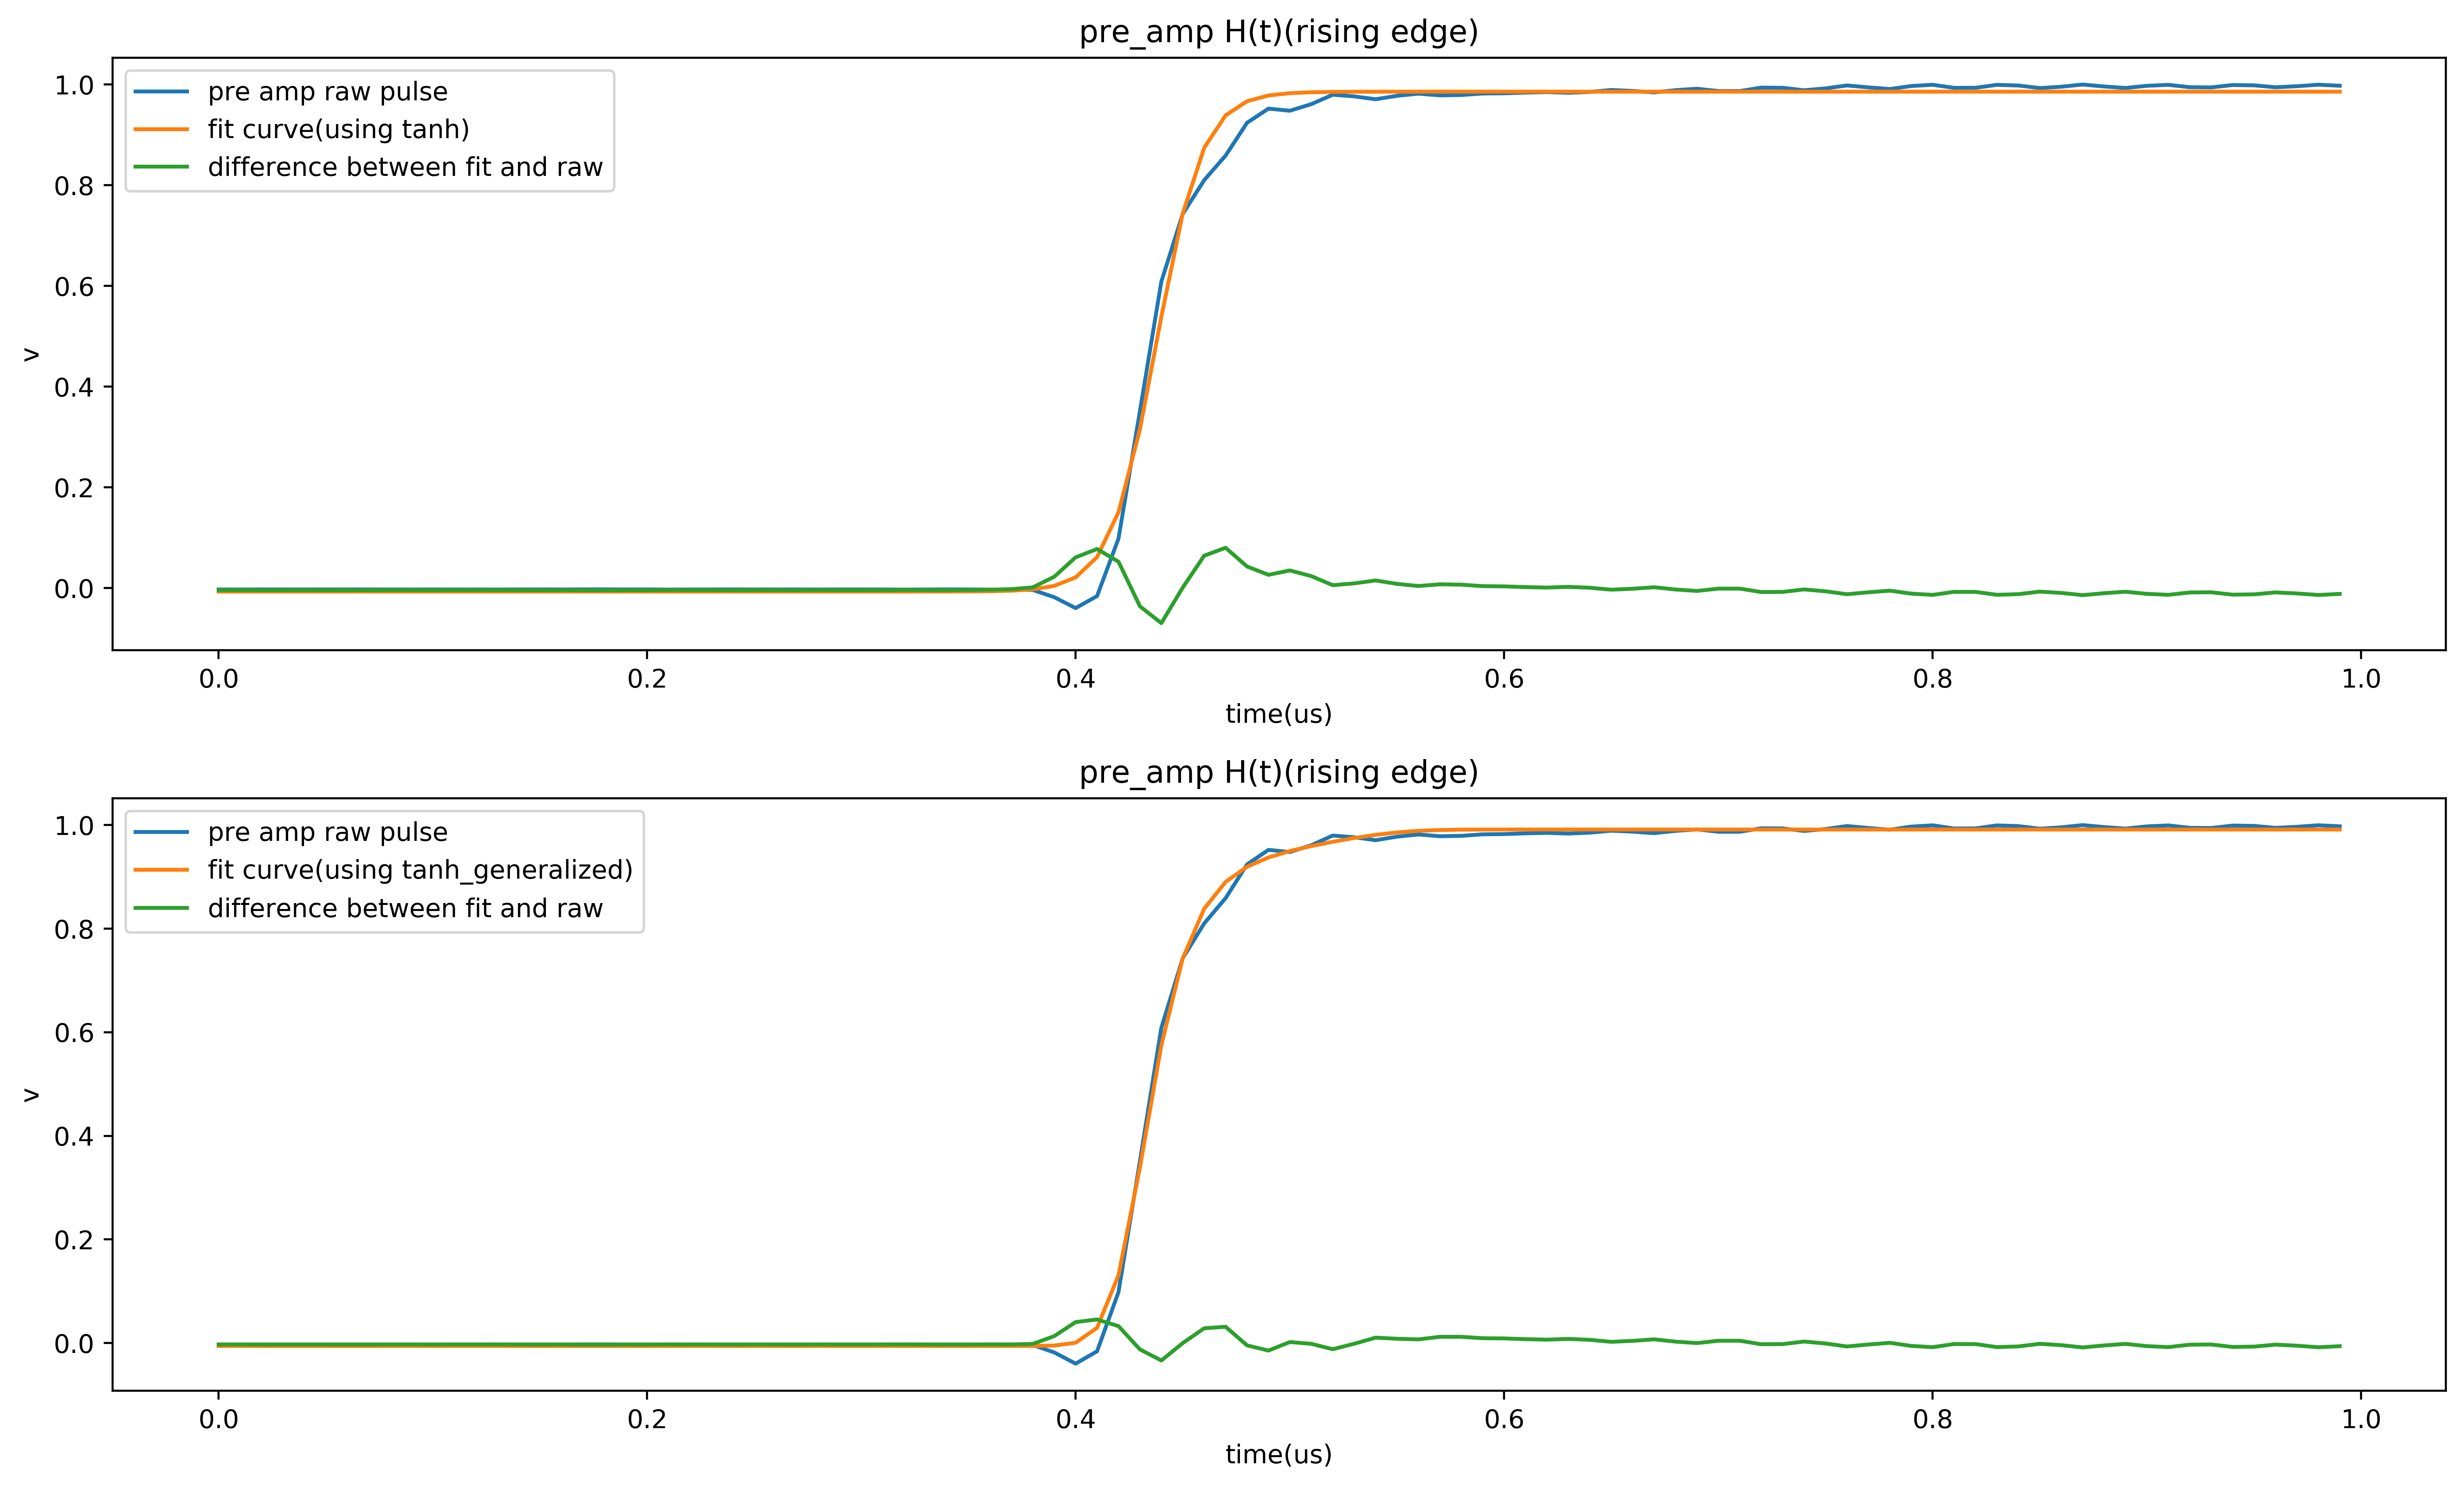

[12.          0.5         3.2         1.23425182  3.13466429  0.49859211
  0.49285769]


In [10]:
# imput the norm_result here

result=AvePulse-damping_component
norm_result=result/result.max()

#set the range of fit and plot here(time)
PlotRangeL=0
PlotRangeH=100

#set plot set here
fig, ax = plt.subplots(2,1,figsize=(14,8),dpi=500)
time=np.linspace(0,0.99,100)

# ax[0].plot(time,norm_result)
# ax[0].set(xlabel='time(us)', ylabel='v',
#        title='pre_amp H(t)')
ax[0].plot(time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],label="pre amp raw pulse")
ax[0].set(xlabel='time(us)', ylabel='v',
       title='pre_amp H(t)(rising edge)')

ax[1].plot(time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],label="pre amp raw pulse")
ax[1].set(xlabel='time(us)', ylabel='v',
       title='pre_amp H(t)(rising edge)')

par_bounds_tanh=([0.48,0.48,0.4,30],[0.52,0.52,0.6,70])

popt,pcov=curve_fit(mytanh,time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],bounds=par_bounds_tanh)
fit_sig_tanh=mytanh(time[PlotRangeL:PlotRangeH],popt[0],popt[1],popt[2],popt[3])
ax[0].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanh,label="fit curve(using tanh)")
ax[0].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanh-norm_result[PlotRangeL:PlotRangeH],label="difference between fit and raw")
print(popt)
ax[0].legend()
#curve fit
par_bounds_tanhg=([5,0.4,0,0,0,0.45,0.45],[12,0.5,3.2,5,5,0.55,0.55])
popt,pcov=curve_fit(tanh_generalized,time[PlotRangeL:PlotRangeH],norm_result[PlotRangeL:PlotRangeH],bounds=par_bounds_tanhg)
print(popt)
fit_sig_tanhg=tanh_generalized(time[PlotRangeL:PlotRangeH],popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
ax[1].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanhg,label="fit curve(using tanh_generalized)")
ax[1].plot(time[PlotRangeL:PlotRangeH],fit_sig_tanhg-norm_result[PlotRangeL:PlotRangeH],label="difference between fit and raw")

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.25)
ax[1].legend()
plt.show()
#leg = ax[1].legend(loc='upper left', fancybox=True, shadow=True)
#fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/rising_fit_compare.png")
print(popt)


In [13]:
print((fit_sig_tanhg-norm_result[PlotRangeL:PlotRangeH]).ptp())
print((fit_sig_tanhg-norm_result[PlotRangeL:PlotRangeH]).std())

0.07922498357517277
0.010227428576600578


In [3]:
def double_betaF(EQ,range_l=0,range_h=1.2,pointN_=12000):
    E=np.linspace(range_l*EQ,range_h*EQ,pointN)
    FE1=0#(E**4+10*E**3+40*E**2+60*E+30)*E*(EQ-E)**5
    FE2=E**3*(E**4+14*E**3+84*E**2+140*E+70)*(EQ-E)**7
    FE=FE1+FE2
    for i in range(pointN):
        if FE[i]<0:
            FE[i]=0
    FE=FE/np.sum(FE)
    return FE

def nless_double_betaF(EQ,FWHM,range_l=0,range_h=1.2,pointN_=12000):
    E=np.linspace(range_l*EQ,range_h*EQ,pointN)
    sigma=FWHM/2.355
    FE=np.exp(-(E-EQ)**2/(2*sigma**2))
    FE=FE/np.sum(FE)
    return FE
    
def convFWHM(FE,FWHM,range_l=0,range_h=1.2,):
    length=FE.size
    FEconv=np.zeros((length,))
    ####conv gauss fun 
    sigma=FWHM/2.355
    Width=0.5
    N=int(2*Width/(range_h-range_l)*length)
    Conv=np.linspace(-Width,Width,N)
    Gauss=np.exp(-(Conv)**2/(2*sigma**2))
    Gauss=Gauss/np.sum(Gauss)
    for i in range(length):
        for tau in range(max(i-int(N/2),0),min(i+int(N/2)-1,length)):
            FEconv[i]+=Gauss[i-tau+(int(N/2)-1)]*FE[tau] 
    return FEconv
    


    
Isotope=pd.DataFrame({'ISO':["Ge76","Xe136","Te130"],
                     'EQ':[2.039,2.458,2.528],
                      'FWHM':[0.12e-2,2.7e-2,0.31e-2],
                     'T2vbb':[1.9,2.2,0.82],
                    'Color':['r','b','g']})       ##T2vbb is unit of 10^21 y
print(Isotope)

range_l=0
range_h=1.2
pointN=12000
E=np.linspace(range_l,range_h,pointN)
ISO_N=3

FE2v=np.zeros((pointN,ISO_N))
FE2vconv=np.zeros((pointN,ISO_N))
FE0v=np.zeros((pointN,ISO_N))
FE0vconv=np.zeros((pointN,ISO_N))
Sum2v=np.zeros((ISO_N,))
Sum0v=np.zeros((ISO_N,))
frac=np.zeros((10,))

for i in range(ISO_N):
    EQ=Isotope.loc[i,'EQ']
    FWHM=EQ*Isotope.loc[i,'FWHM']
    print(EQ,FWHM)
    FE2v[:,i]=double_betaF(EQ,pointN_=pointN)
    FE2vconv[:,i]=convFWHM(FE2v[:,i],FWHM)
    FE0vconv[:,i]=nless_double_betaF(EQ,FWHM,pointN_=pointN)

Sum2v=np.sum(FE2vconv,axis=0)
Sum0v=np.sum(FE0vconv,axis=0)
print(Sum2v,Sum0v)




#fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=500)
    


# ResPulse[0:65]=fit_sig_tanhg[35:100]/fit_sig_tanhg[35:100].max()

# ax[0].set(xlabel='time(us)')
# ax[1].plot(np.linspace(0,7.99,800),ResPulse[0:800])
# ax[1].set(xlabel='time(us)')
# fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/ht.png")
#np.save("E:/CDEX/ovbb/WaveSimulation/response/ResPulse.npy",ResPulse)

     ISO     EQ    FWHM  T2vbb Color
0   Ge76  2.039  0.0012   1.90     r
1  Xe136  2.458  0.0270   2.20     b
2  Te130  2.528  0.0031   0.82     g
2.039 0.0024468
2.458 0.06636600000000001
2.528 0.0078368
[1.         0.99992661 0.99999999] [1. 1. 1.]


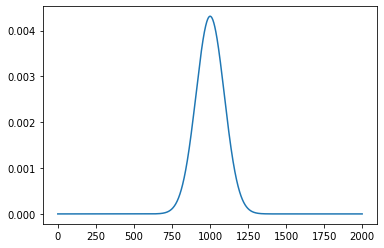

In [66]:
FE=np.zeros((pointN,))
E=np.linspace(range_l,range_h,pointN)
FE[10000]=1
FWHM=7.1*2.458/100
FEconv=convFWHM(FE,FWHM)
plt.plot(FEconv[9000:11000])

3.711655616470447e-08 9865 10135


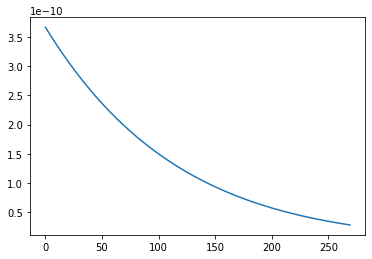

In [6]:
def convert(range_l,range_h,pointN,FWHM):
    start=int(pointN*(1-0.5*FWHM-range_l)/(range_h-range_l))
    end=int(pointN*(1+0.5*FWHM-range_l)/(range_h-range_l))
    return start, end
    
    
start,end=convert(range_l,range_h,pointN,0.027)    
frac[0]=np.sum(FE2vconv[start:end:,1])
frac[1]=np.sum(FE0vconv[start:end:,1])
print(frac[0],start,end)
plt.plot(FE2vconv[start:end:,1])

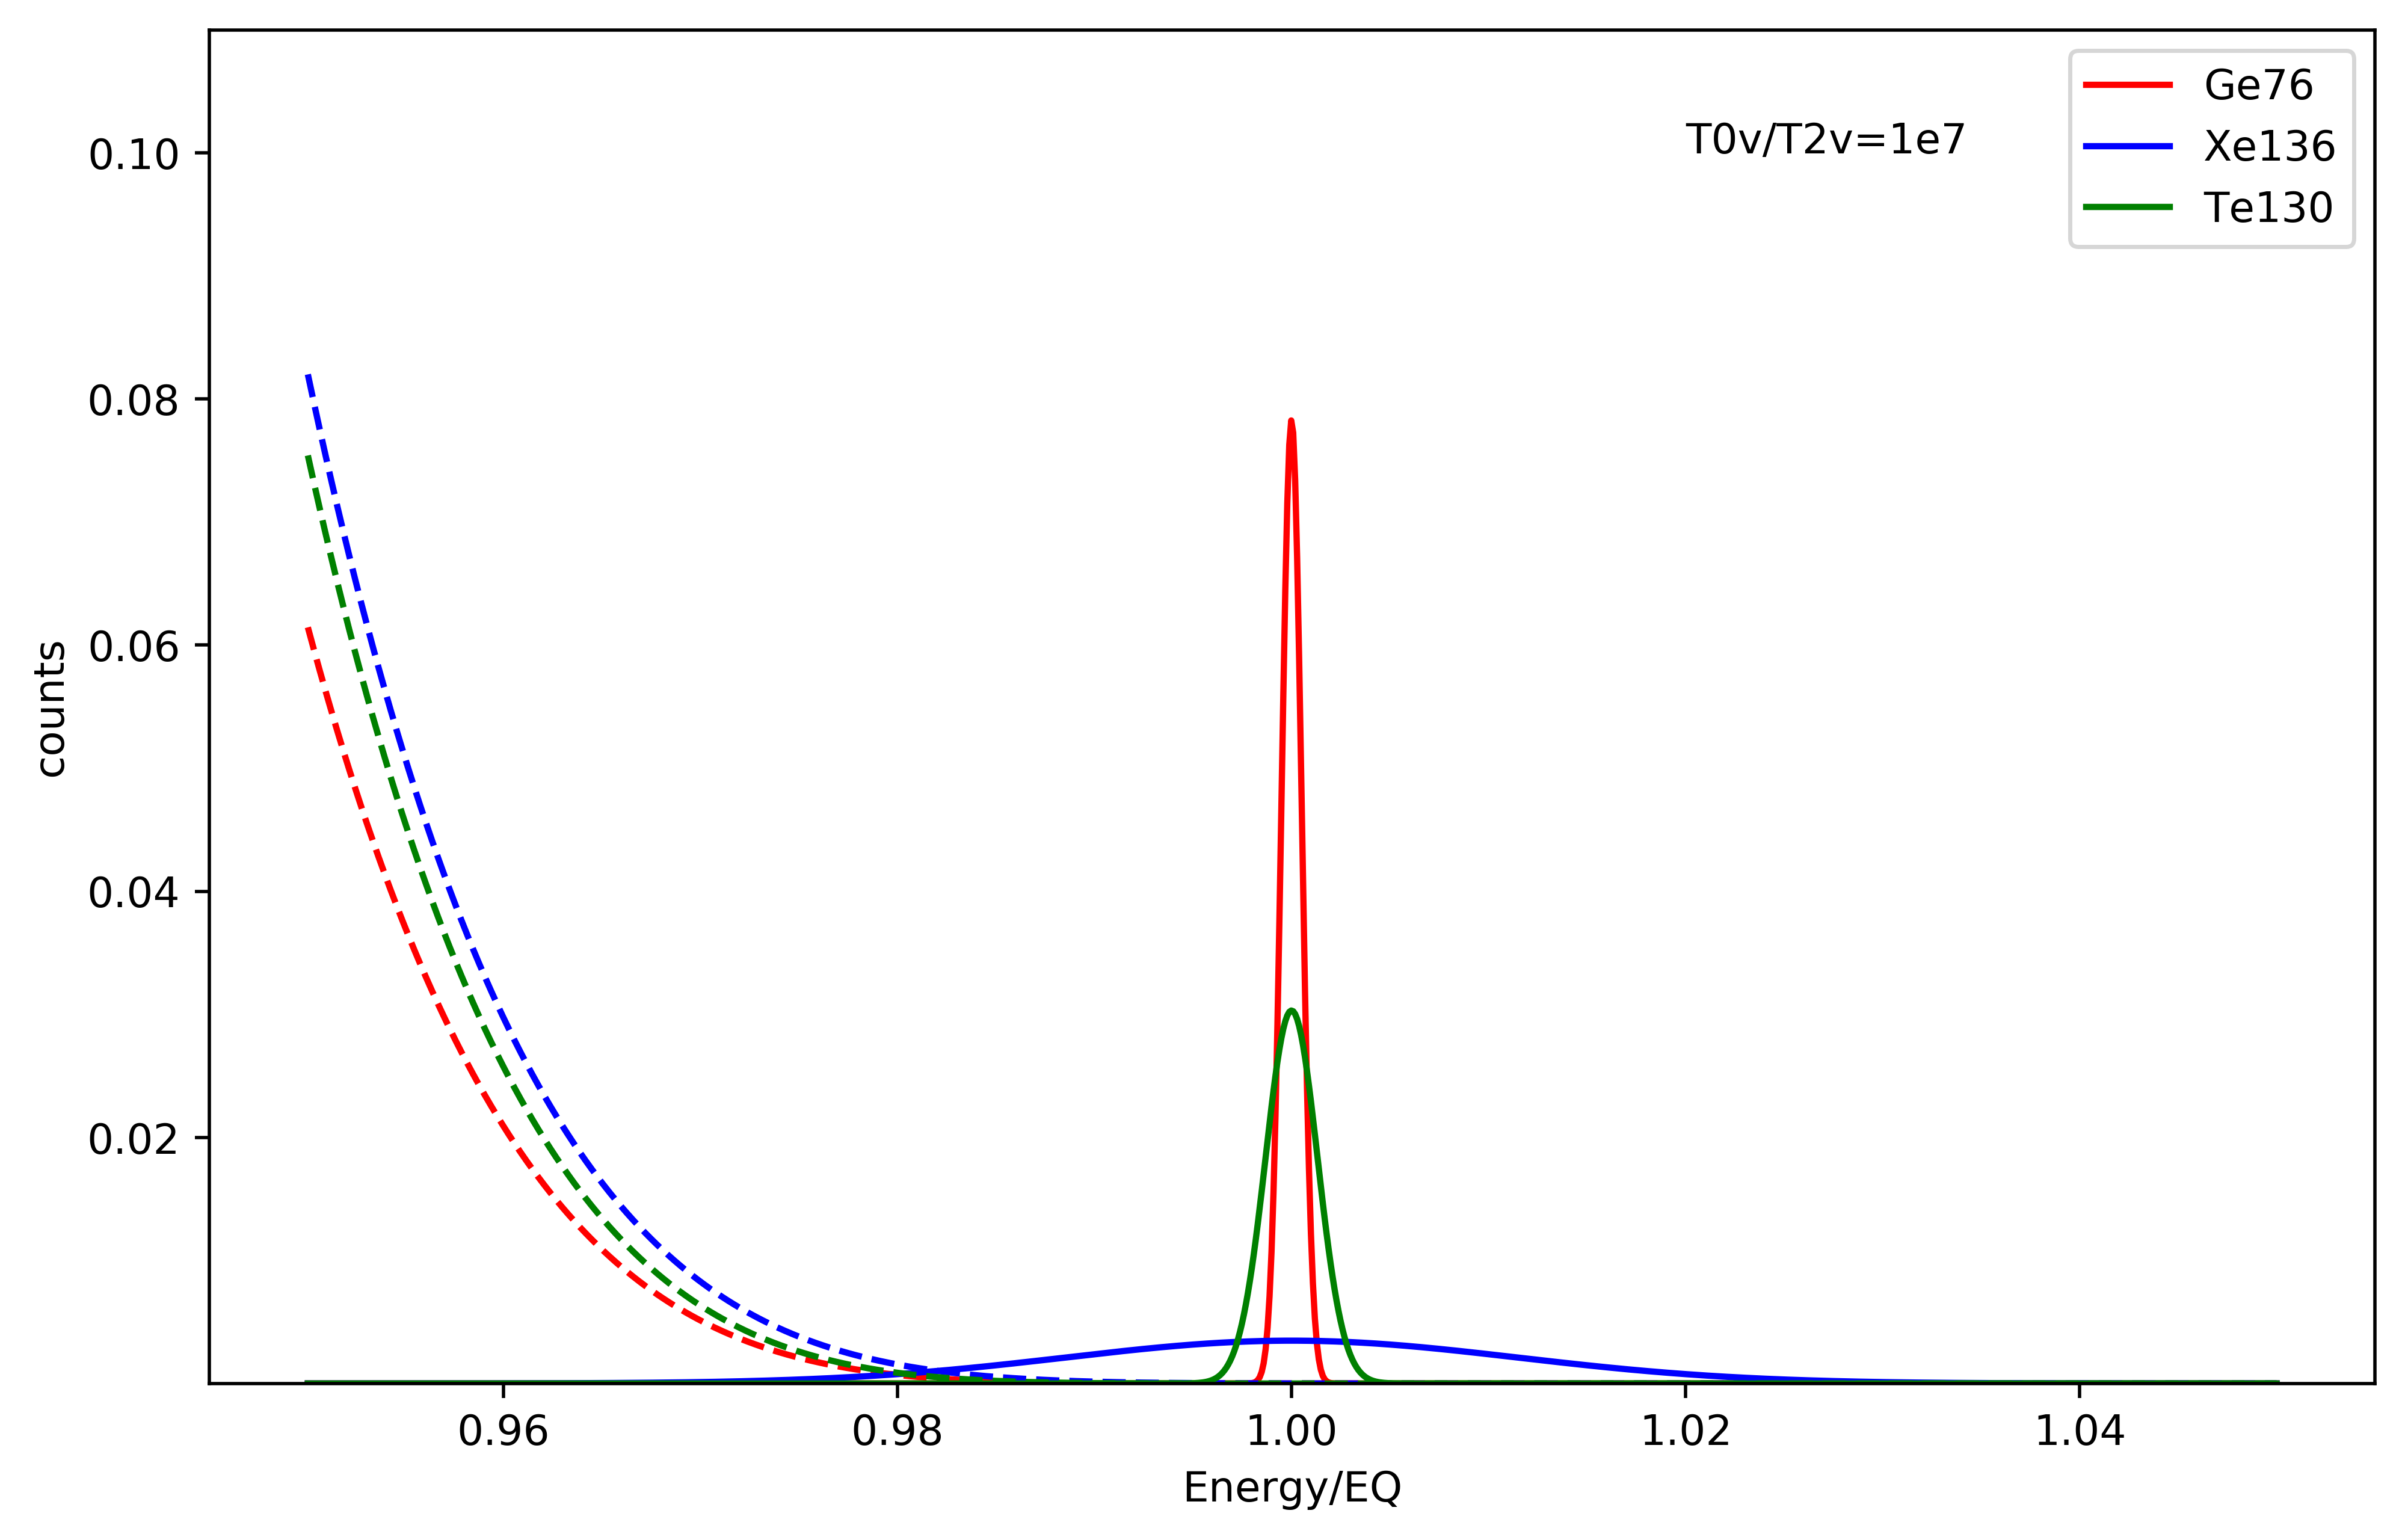

In [61]:
#plot parameter:
pltRL=9500
pltRH=10500
fracT=1e7
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=500)
t=("T0v/T2v=1e7")
plt.text(1.02,0.1,t)
for i in range(ISO_N):
    ax.plot(E[pltRL:pltRH],FE2vconv[pltRL:pltRH,i]*fracT,color=Isotope.loc[i,'Color'],linestyle='--')
    ax.plot(E[pltRL:pltRH],FE0vconv[pltRL:pltRH,i],color=Isotope.loc[i,'Color'],label=Isotope.loc[i,'ISO'])
    ax.legend()
#ax.set_yscale("log")
ax.set(xlabel="Energy/EQ",ylabel="counts")
plt.ylim(1e-5,0.11)
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                wspace=0.15, hspace=0.25)
plt.show()
fig.savefig("E:/CDEX/ovbb/WaveSimulation/figure/DBDSpectrum_linear_EXO.png")
    

0.9999549001971424 0.9999999999999999
